In [ ]:
!pip install catboost

In [3]:
import pandas as pd
import numpy as np
from pandas.core.nanops import nanmean
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf
from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [4]:
DATA_PATH = 'drive/MyDrive/youtube/'

In [ ]:
mydateparser = lambda x: datetime.datetime.strptime(x, '%d-%m-%y')

# Загрузка данных

In [105]:
df = pd.read_csv(DATA_PATH + 'time_series_to_may.csv',
                 index_col=0,
                 header=0,
                 parse_dates=['date'])

In [79]:
df.head()

count
date             
2021-12-31   1962
2022-01-01   1156
2022-01-02   1378
2022-01-03   1553
2022-01-04   1759

In [17]:
df.dtypes

count    int64
dtype: object

<Axes: title={'center': 'Динамика публикации видео по дням'}, xlabel='date'>

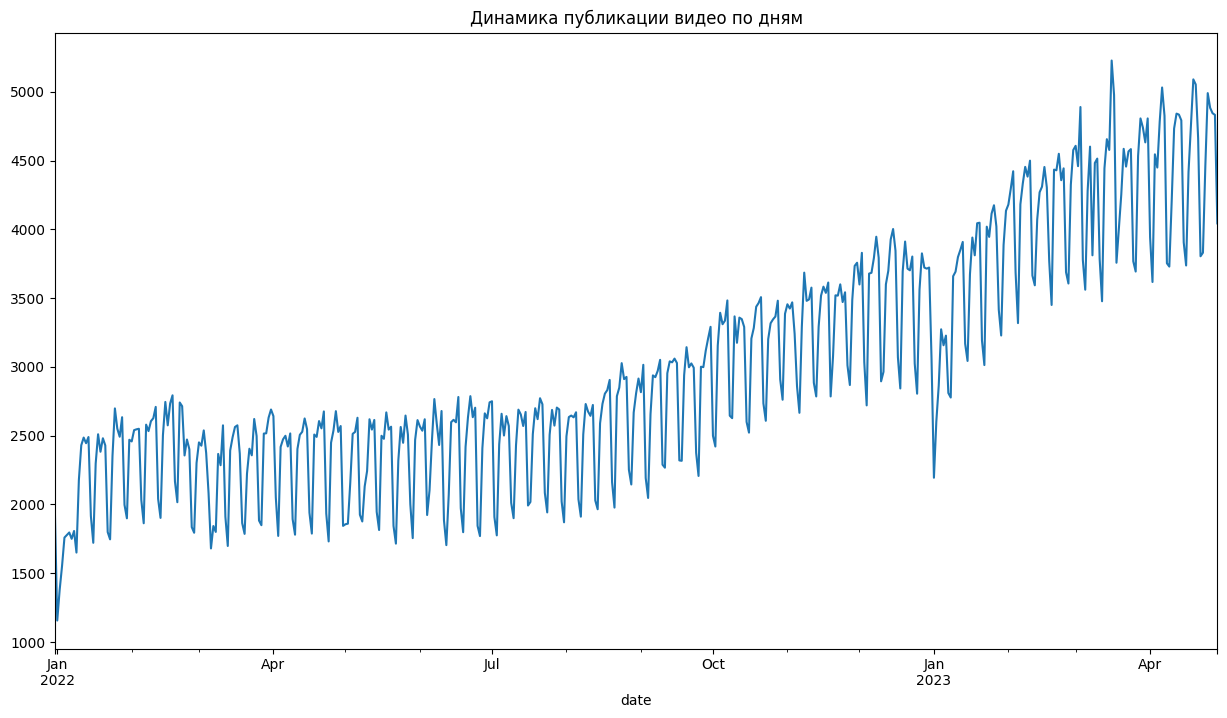

In [80]:
plt.figure(figsize=(15, 8))
plt.title('Динамика публикации видео по дням')
df['count'].plot()

Разложения ряда на составляющие

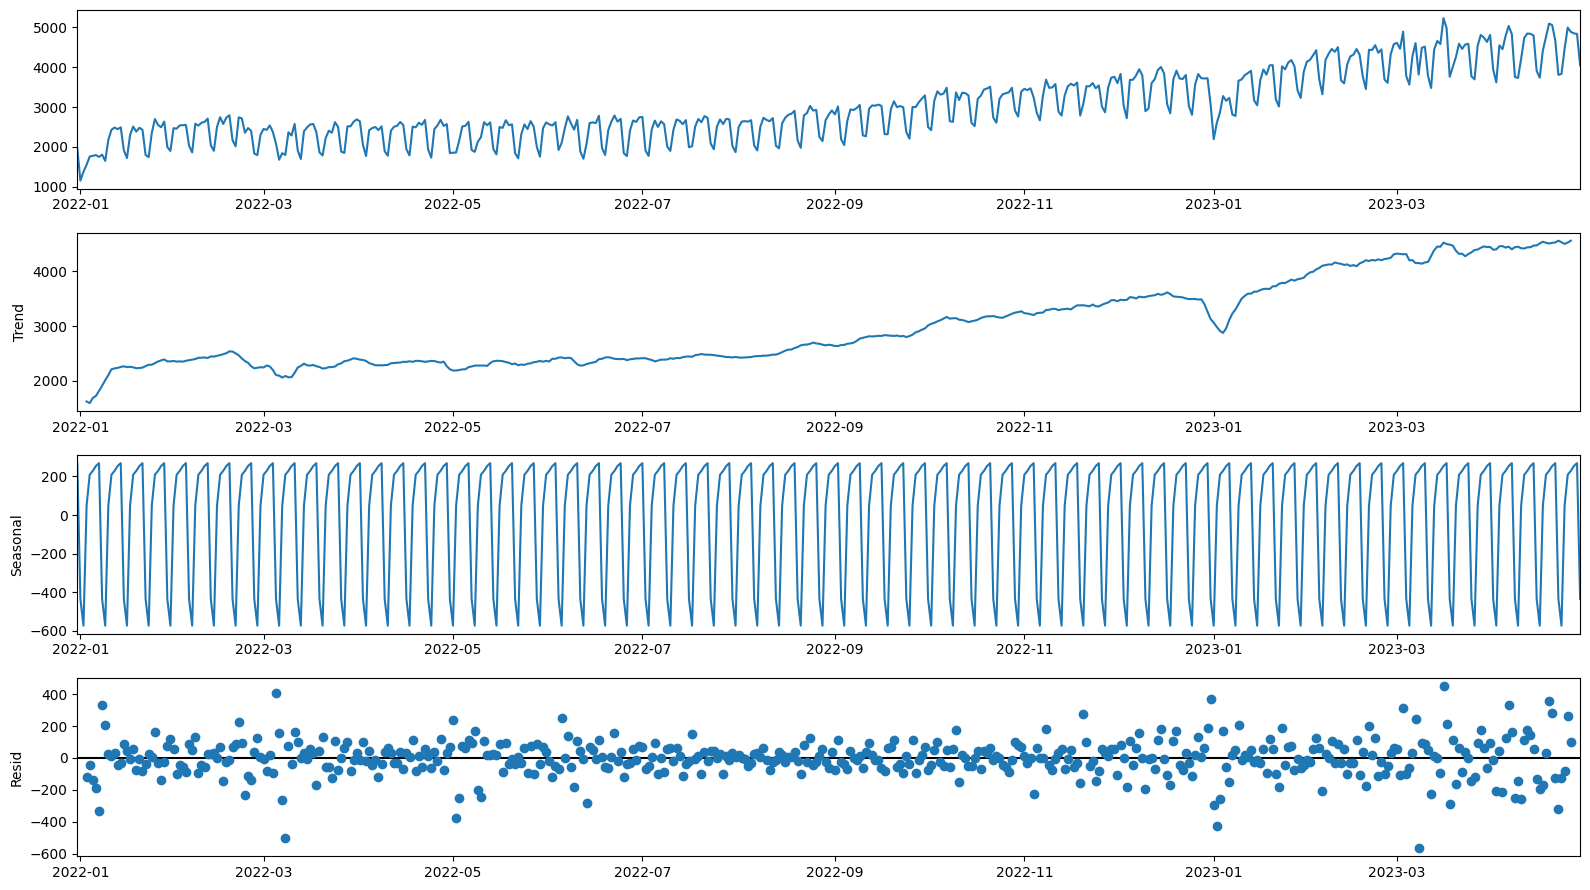

In [81]:
result = seasonal_decompose(df, model='additive')
fig=result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Мультипликативный тренд, аддитивная сезонность

In [106]:
train = df['2021-12-31	':'2023-03-30']
test  = df['2023-03-31':]
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)

Train Dataset: (455, 1)
Test Dataset: (30, 1)


# Модель сезонного скользящего среднего RMSE - 181.05

In [102]:
class SimpleModel:
  def __init__(self, window: int=1, seasonality: int= 1):
    self.window = window
    self.seasonality = seasonality
    self.shift = self.window * self.seasonality

  def predict(self, df, horizon):
    series = df[-self.shift:].values
    print(f'последние shift наблюдений из обучающей выборки: \n{series}\n')
    res= np.append(series, np.zeros(horizon))
    print(f'массив из последних shift наблюдений обучающей выборки',
          f'и HORIZON нулевых значений:\n{res}\n')
    for i in range(self.shift, len(res)):
      print('окно:', res[i - self.shift : i : self.seasonality])
      res[i] = res[i - self.shift : i : self.seasonality].mean()
      print('прогноз', res[i])
      pred = res[-horizon:]

    return pred

In [ ]:
s = SimpleModel(window=3, seasonality=7)
predictions = s.predict(train, horizon=30)

In [180]:
rmse = mean_squared_error(test, predictions, squared=False)
print(rmse)

181.05301031946098


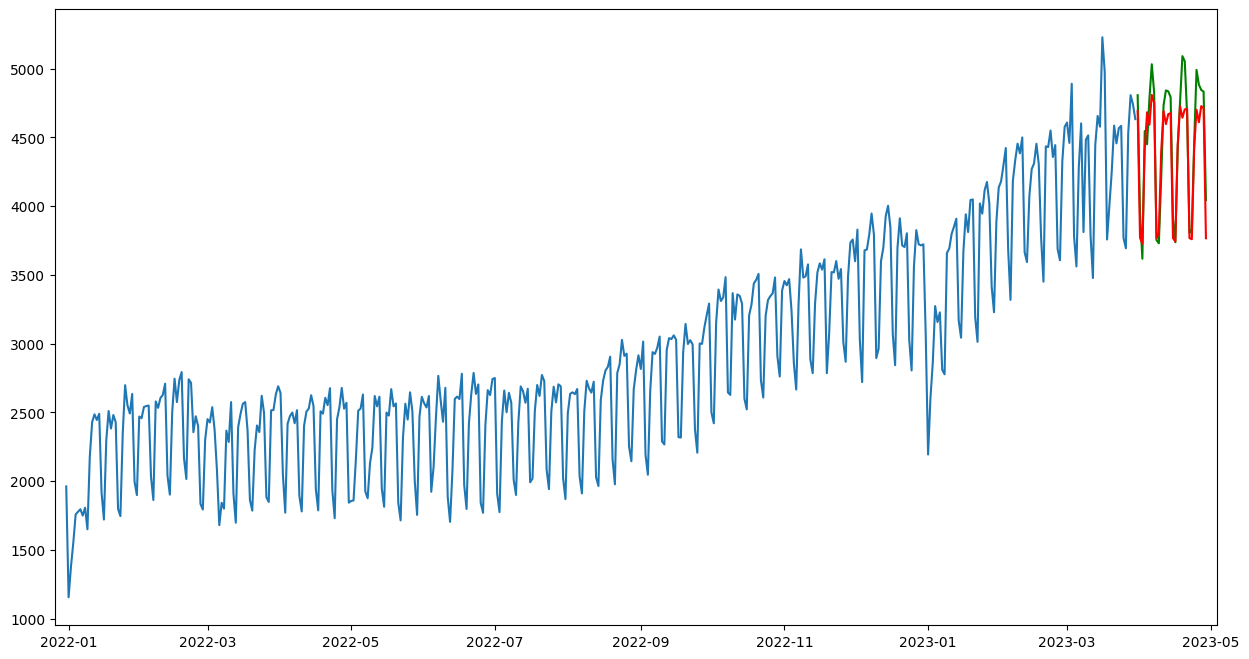

In [181]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(train, label='train')
ax.plot(test, color='green', label='test')
ax.plot(pd.Series(predictions, index=test.index), color='red', label='preds')
ax.margins(x=0.01)

# Модель тройного экспоненциального сглаживания RMSE - 160.16

In [163]:
triple = ExponentialSmoothing(train, trend = 'multiplicative',
                              seasonal='add',
                              seasonal_periods=7).fit(smoothing_level=0.65,
                                                      smoothing_trend=0.09,
                                                      smoothing_seasonal=0.08, optimized=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [164]:
triple_preds = triple.forecast(len(test))

In [165]:
triple_rmse = mean_squared_error(test, triple_preds, squared=False)
print(triple_rmse)

160.16859550975565


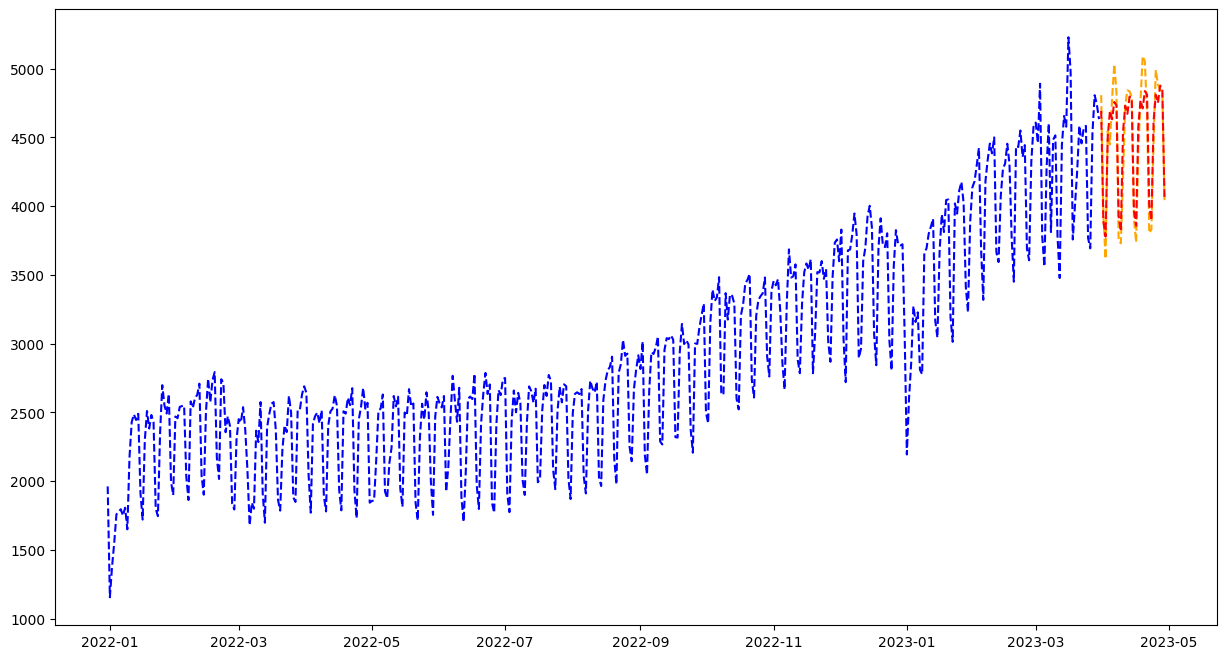

In [166]:
plt.figure(figsize=(15, 8))
plt.plot(train, 'b--', label='train')
plt.plot(test, color='orange', linestyle='--', label='test')
plt.plot(triple_preds, 'r--', label='preds')

# Градиентный бустинг RMSE - 406.41

In [182]:
def train_and_plot_forecast(
  tr, y_tr, tst, y_tst,
  cat_feat=None,
  preprocess_trend_and_seasonality=None,
  y_tr_trend_pred=None, y_tst_trend_pred=None,
  y_tr_seasonal_coef=None, y_tst_seasonal_coef=None,
  text_for_legend=None):

  if preprocess_trend_and_seasonality == None and any(
      [i is not None for i in [y_tr_trend_pred, y_tst_trend_pred,
                               y_tr_seasonal_coef, y_tst_seasonal_coef]]):
    raise ValueError()

  if preprocess_trend_and_seasonality == 'fast' and (
      y_tr_trend_pred is None or y_tst_trend_pred is None):

    raise ValueError()

  if preprocess_trend_and_seasonality == 'full' and any(
      [i is None for i in [y_tr_trend_pred, y_tst_trend_pred,
                               y_tr_seasonal_coef, y_tst_seasonal_coef]]):
    raise ValueError()

  ctbst = CatBoostRegressor(random_seed=42,
                            logging_level='Silent')
  ctbst.fit(tr, y_tr, cat_features=cat_feat, plot=False)

  ctbst_predictions = ctbst.predict(tst)
  ctbst_predictions = pd.Series(ctbst_predictions,
                                index=y_tst.index)

  cols = list(tr.columns[tr.dtypes == 'object'])
  for c in cols:
    tr[c] = tr[c].astype('category').cat.codes
    tst[c] = tst[c].astype('category').cat.codes

  lgbm = LGBMRegressor(random_seed=42)
  lgbm.fit(tr, y_tr)

  lgbm_predictions = lgbm.predict(tst)
  lgbm_predictions = pd.Series(lgbm_predictions,
                               index = y_tst.index)

  linear_lgbm = LGBMRegressor(random_seed=42,
                              linear_tree=True,
                              min_data_in_leaf=100,
                              objective='l1')
  linear_lgbm.fit(tr, y_tr)

  linear_lgbm_predictions = linear_lgbm.predict(tst)
  linear_lgbm_predictions = pd.Series(linear_lgbm_predictions,
                                      index=y_tst.index)

  xgbst = XGBRegressor(seed=42)
  xgbst.fit(tr, y_tr)

  xgbst_predictions = xgbst.predict(tst)
  xgbst_predictions = pd.Series(xgbst_predictions,
                                index=y_tst.index)

  linear_xgbst = XGBRegressor(seed=42,
                              booster='gblinear')
  linear_xgbst.fit(tr, y_tr)

  linear_xgbst_predictions = linear_xgbst.predict(tst)
  linear_xgbst_predictions = pd.Series(linear_xgbst_predictions,
                                       index=y_tst.index)

  if preprocess_trend_and_seasonality == None:
    pass

  if preprocess_trend_and_seasonality == 'fast_mul':
    ctbst_predictions = ctbst_predictions * y_tst_trend_pred
    lgbm_predictions = lgbm_predictions * y_tst_trend_pred
    linear_lgbm_predictions = linear_lgbm_predictions * y_tst_trend_pred
    xgbst_predictions = xgbst_predictions * y_tst_trend_pred
    linear_xgbst_predictions = linear_xgbst_predictions * y_tst_trend_pred
    y_tr = y_tr * y_tr_trend_pred

  if preprocess_trend_and_seasonality == 'fast_add':
    ctbst_predictions = ctbst_predictions + y_tst_trend_pred
    lgbm_predictions = lgbm_predictions + y_tst_trend_pred
    linear_lgbm_predictions = linear_lgbm_predictions + y_tst_trend_pred
    xgbst_predictions = xgbst_predictions + y_tst_trend_pred
    linear_xgbst_predictions = linear_xgbst_predictions + y_tst_trend_pred
    y_tr = y_tr + y_tr_trend_pred

  if preprocess_trend_and_seasonality == 'full_mul':
    ctbst_predictions = (
        ctbst_predictions + y_tst_trend_pred) * y_tst_seasonal_coef
    lgbm_predictions = (
        lgbm_predictions + y_tst_trend_pred) * y_tst_seasonal_coef
    linear_lgbm_predictions = (
        linear_lgbm_predictions + y_tst_trend_pred) * y_tst_seasonal_coef
    xgbst_predictions = (
        xgbst_predictions + y_tst_trend_pred) * y_tst_seasonal_coef
    linear_xgbst_predictions = (
        linear_xgbst_predictions + y_tst_trend_pred) * y_tst_seasonal_coef
    y_tr = (
        y_tr + y_tr_trend_pred) * y_tr_seasonal_coef

  if preprocess_trend_and_seasonality == 'full_add':
    ctbst_predictions = (
        ctbst_predictions + y_tst_trend_pred) + y_tst_seasonal_coef
    lgbm_predictions = (
        lgbm_predictions + y_tst_trend_pred) + y_tst_seasonal_coef
    linear_lgbm_predictions = (
        linear_lgbm_predictions + y_tst_trend_pred) + y_tst_seasonal_coef
    xgbst_predictions = (
        xgbst_predictions + y_tst_trend_pred) + y_tst_seasonal_coef
    linear_xgbst_predictions = (
        linear_xgbst_predictions + y_tst_trend_pred) + y_tst_seasonal_coef
    y_tr = (
        y_tr + y_tr_trend_pred) + y_tr_seasonal_coef

  rmse_ctbst = mean_squared_error(y_tst, ctbst_predictions, squared=False)
  rmse_lgbm = mean_squared_error(y_tst, lgbm_predictions, squared=False)
  rmse_lin_lgbm = mean_squared_error(y_tst, linear_lgbm_predictions, squared=False)
  rmse_xgbst = mean_squared_error(y_tst, xgbst_predictions, squared=False)
  rmse_lin_xgbst = mean_squared_error(y_tst, linear_xgbst_predictions, squared=False)

  if text_for_legend == None:
    string = 'прогнозы CatBoost'
    string2 = 'прогнозы LightGBM'
    string3 = 'прогнозы LightGBM с линейными моделями в листьях'
    string4 = 'прогнозы XGBoost'
    string5 = 'прогнозы XGBoost на линейных моделях'
  else:
    string = f'прогнозы CatBoost\n{text_for_legend}'
    string2 = f'прогнозы LightGBM\n{text_for_legend}'
    string3 = f'прогнозы LightGBM с линейными моделями в листьях\n{text_for_legend}'
    string4 = f'прогнозы XGBoost\n{text_for_legend}'
    string5 = f'прогнозы XGBoost на линейных моделях\n{text_for_legend}'

  fig, ax = plt.subplots(figsize=(16, 10))
  ax.plot(y_tr,
          color='black',
          label = 'обучающая выборка',
          marker = 'o')
  ax.plot(y_tst,
          color='green',
          label = 'тестовая выборка',
          marker = 'o')
  ax.plot(ctbst_predictions, color='red', label = string)
  ax.plot(lgbm_predictions, color='blue', label = string2)
  ax.plot(linear_lgbm_predictions, color='magenta', label = string3)
  ax.plot(xgbst_predictions, color='orange', label = string4)
  ax.plot(linear_xgbst_predictions, color='lime', linestyle='dotted', label = string5)

  ax.set_title(f'RMSE catboost: {rmse_ctbst:.2f}, '
               f'RMSE lightgbm: {rmse_lgbm:.2f}, '
               f'RMSE lin_lightgbm: {rmse_lin_lgbm:.2f}, '
               f'RMSE xgboost: {rmse_xgbst:.2f}, '
               f'RMSE lin_xgb: {rmse_lin_xgbst:.2f}',
               size=18)
  ax.margins(x=0.01)
  ax.tick_params(labelrotation=90)
  ax.xaxis.set_major_locator(md.DayLocator(interval=2))
  ax.grid()
  ax.legend()

In [183]:
X_train = pd.DataFrame({'date': train.index.view(np.int64) // 10**9})
X_test = pd.DataFrame({'date': test.index.view(np.int64) // 10**9})

In [184]:
y_train = train['count']
y_test = test['count']

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


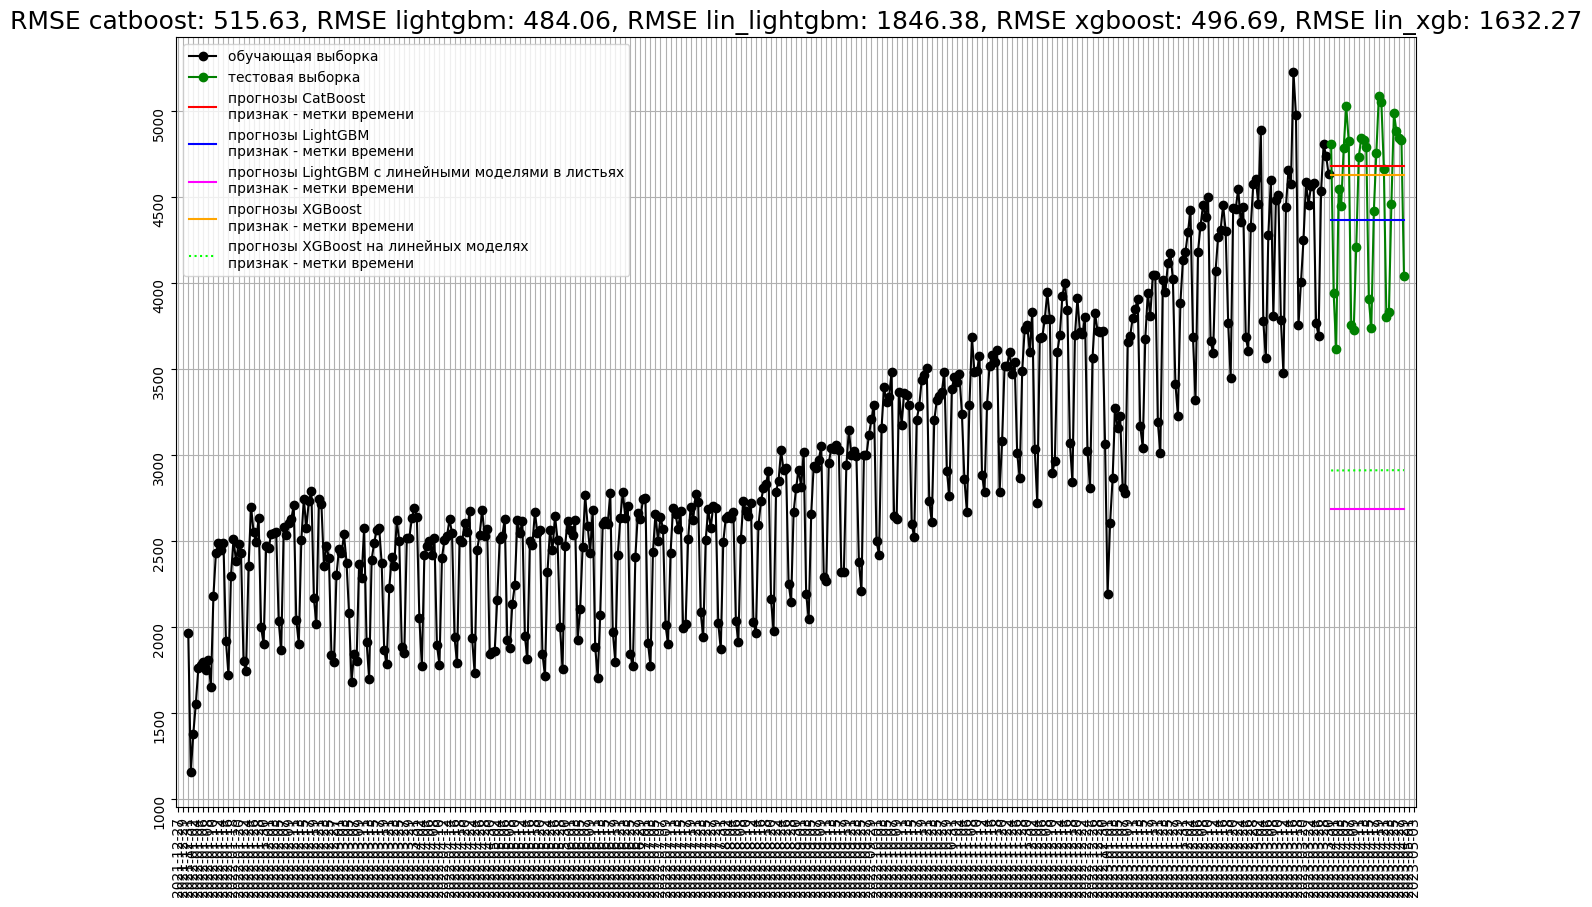

In [185]:
train_and_plot_forecast(X_train, y_train, X_test, y_test, text_for_legend='признак - метки времени')

# Utils

In [186]:
def create_calendar_vars(df):
  df['month'] = df.index.month
  def get_season(month):
    if (month > 11 or month < 3):
      return 'WINTER'
    elif (month == 3 or month <=5):
      return 'SPRING'
    elif (month >= 6 and month < 9):
      return 'SUMMER'
    else:
      return 'FALL'

  df['season'] = df['month'].apply(lambda x: get_season(x))
  df['quarter'] = df.index.quarter
  return df

In [187]:
def fast_train_test_split(data, target, test_size):
  X_train, X_test, y_train, y_test = train_test_split(
      data.drop(target, axis=1),
      data[target],
      test_size=test_size,
      shuffle=False)
  return X_train, X_test, y_train, y_test

In [188]:
def fourier(series_index, period=None, order=None, mods=None, out_column=None):
  def _get_column_name(mod):
    if out_column is None:
      return f'Fourier_{mod}'
    else:
      return f'{out_column}_{mod}'
  if period < 2:
    raise ValueError('Period should be at least 2')
  if order is not None and mods is None:
    if order < 1 or order > ceil(period/2):
      raise ValueError('Order should be within' + '[1, ceil(period/2)] range')
    mods = [mod for mod in range(1, 2 * order + 1) if mod < period]
  elif mods is not None and order is None:
    if min(mods) < 1 or max(mods) >= period:
      raise ValueError('Every mod should be within' + '[1, int(period)] range')
  else:
    raise ValueError('There should be exactly one' + 'option set: order or mods')

  features = pd.DataFrame(index=series_index)
  elapsed = np.arange(features.shape[0]) / period
  for mod in mods:
    order = (mod + 1) // 2
    is_cos = mod % 2 == 0
    features[_get_column_name(mod)] = np.sin(2 * np.pi * order * elapsed + np.pi / 2 * is_cos)

  return features

In [189]:
def moving_stats(series, alpha=1, seasonality=1,
                 periods=1, min_periods=1, window=4,
                 aggfunc='mean', fillna=None):
  size = window if window != -1 else len(series) - 1
  alpha_range = [alpha ** i for i in range(0, size)]
  min_required_len = max(min_periods - 1, 0) * seasonality + 1

  def get_required_lags(series):
    return pd.Series(series.values[::-1][:: seasonality])

  def aggregate_window(series):
    tmp_series = get_required_lags(series)
    size = len(tmp_series)
    tmp = tmp_series * alpha_range[-size:]

    if aggfunc == 'mdad':
      return tmp.to_frame().agg(lambda x: np.nanmedian(np.abs(x - np.nanmedian(x))))

    else:
      return tmp.agg(aggfunc)

  features = series.shift(periods=periods).rolling(
      window=seasonality * window
      if window != -1 else len(series) - 1,
      min_periods = min_required_len).aggregate(
      aggregate_window)

  if fillna is not None:
    features.fillna(fillna, inplace=True)
  return features

# Добавление признаков

### Признаки - месяц, сезон, квартал RMSE - 436.86

In [190]:
df = create_calendar_vars(df)

In [191]:
df

count  month  season  quarter
date                                     
2021-12-31   1962     12  WINTER        4
2022-01-01   1156      1  WINTER        1
2022-01-02   1378      1  WINTER        1
2022-01-03   1553      1  WINTER        1
2022-01-04   1759      1  WINTER        1
...           ...    ...     ...      ...
2023-04-25   4990      4  SPRING        2
2023-04-26   4883      4  SPRING        2
2023-04-27   4844      4  SPRING        2
2023-04-28   4832      4  SPRING        2
2023-04-29   4043      4  SPRING        2

[485 rows x 4 columns]

In [192]:
HORIZON = 30

In [193]:
X_train, X_test, y_train, y_test = fast_train_test_split(df, 'count', HORIZON)

In [194]:
categorical_features = np.where(X_train.dtypes == object)[0]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


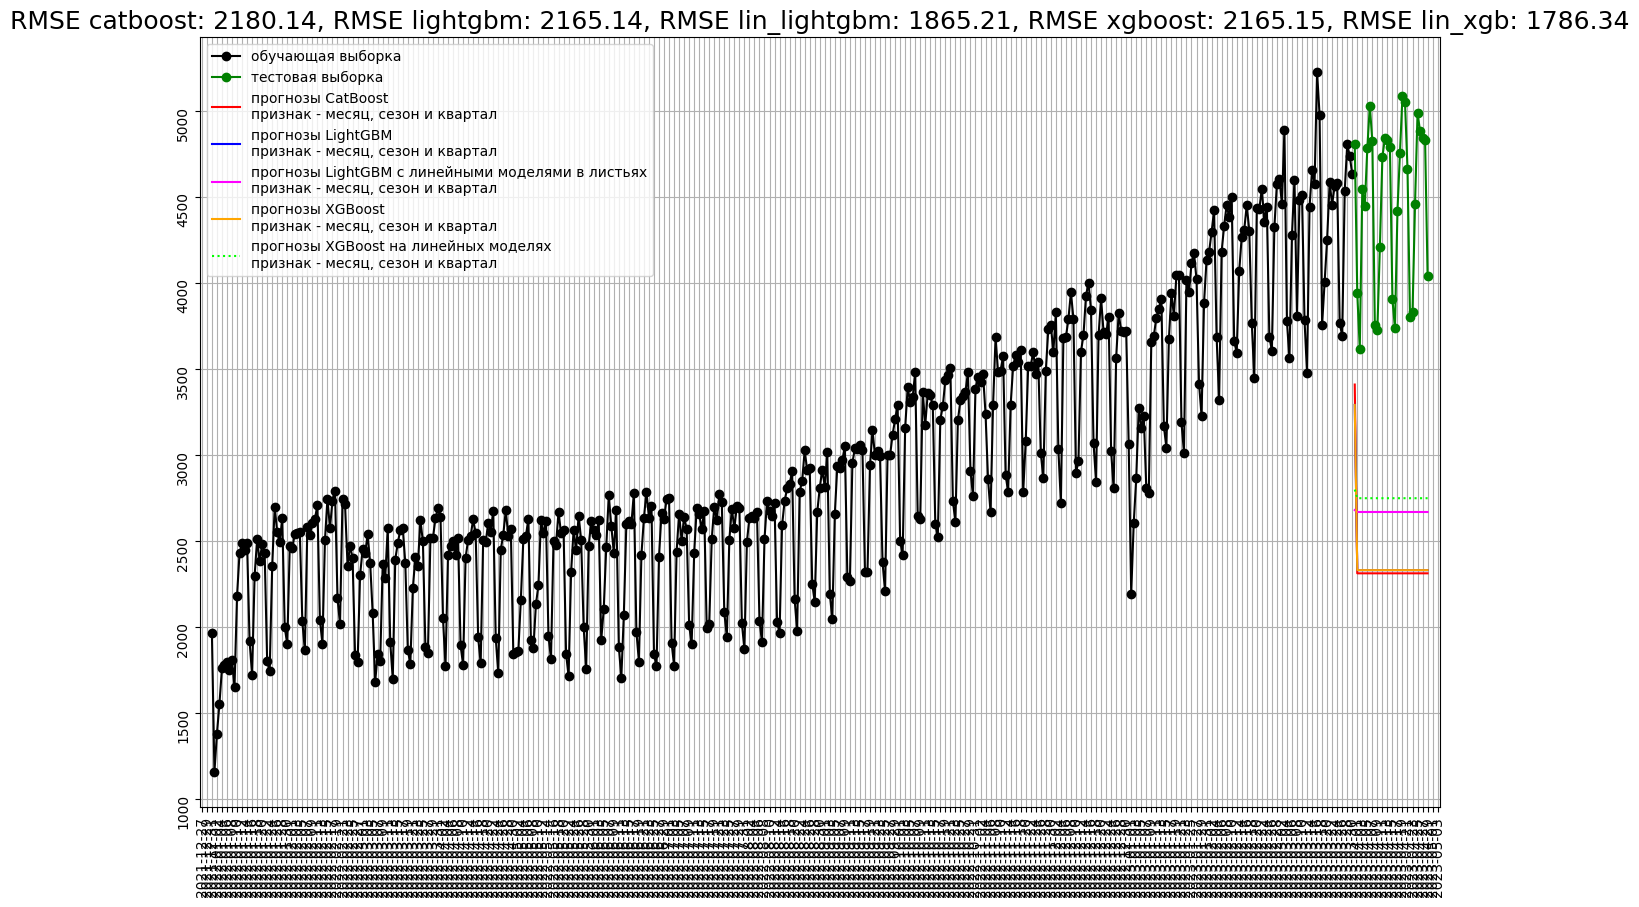

In [195]:
train_and_plot_forecast(X_train, y_train, X_test, y_test,
                        cat_feat=categorical_features,
                        text_for_legend='признак - месяц, сезон и квартал')

### Признаки - месяц, сезон, квартал, ряды Фурье RMSE - 245.54

In [196]:
fourier_feat_year = fourier(df.index,
                            out_column = 'fourier_year',
                            period = 7,
                            order=1)

In [197]:
df_fourier = pd.concat([df, fourier_feat_year], axis=1)
df_fourier

count  month  season  quarter  fourier_year_1  fourier_year_2
date                                                                     
2021-12-31   1962     12  WINTER        4    0.000000e+00        1.000000
2022-01-01   1156      1  WINTER        1    7.818315e-01        0.623490
2022-01-02   1378      1  WINTER        1    9.749279e-01       -0.222521
2022-01-03   1553      1  WINTER        1    4.338837e-01       -0.900969
2022-01-04   1759      1  WINTER        1   -4.338837e-01       -0.900969
...           ...    ...     ...      ...             ...             ...
2023-04-25   4990      4  SPRING        2   -4.338837e-01       -0.900969
2023-04-26   4883      4  SPRING        2   -9.749279e-01       -0.222521
2023-04-27   4844      4  SPRING        2   -7.818315e-01        0.623490
2023-04-28   4832      4  SPRING        2   -9.794698e-15        1.000000
2023-04-29   4043      4  SPRING        2    7.818315e-01        0.623490

[485 rows x 6 columns]

In [198]:
X_train, X_test, y_train, y_test = fast_train_test_split(df_fourier, 'count', HORIZON)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


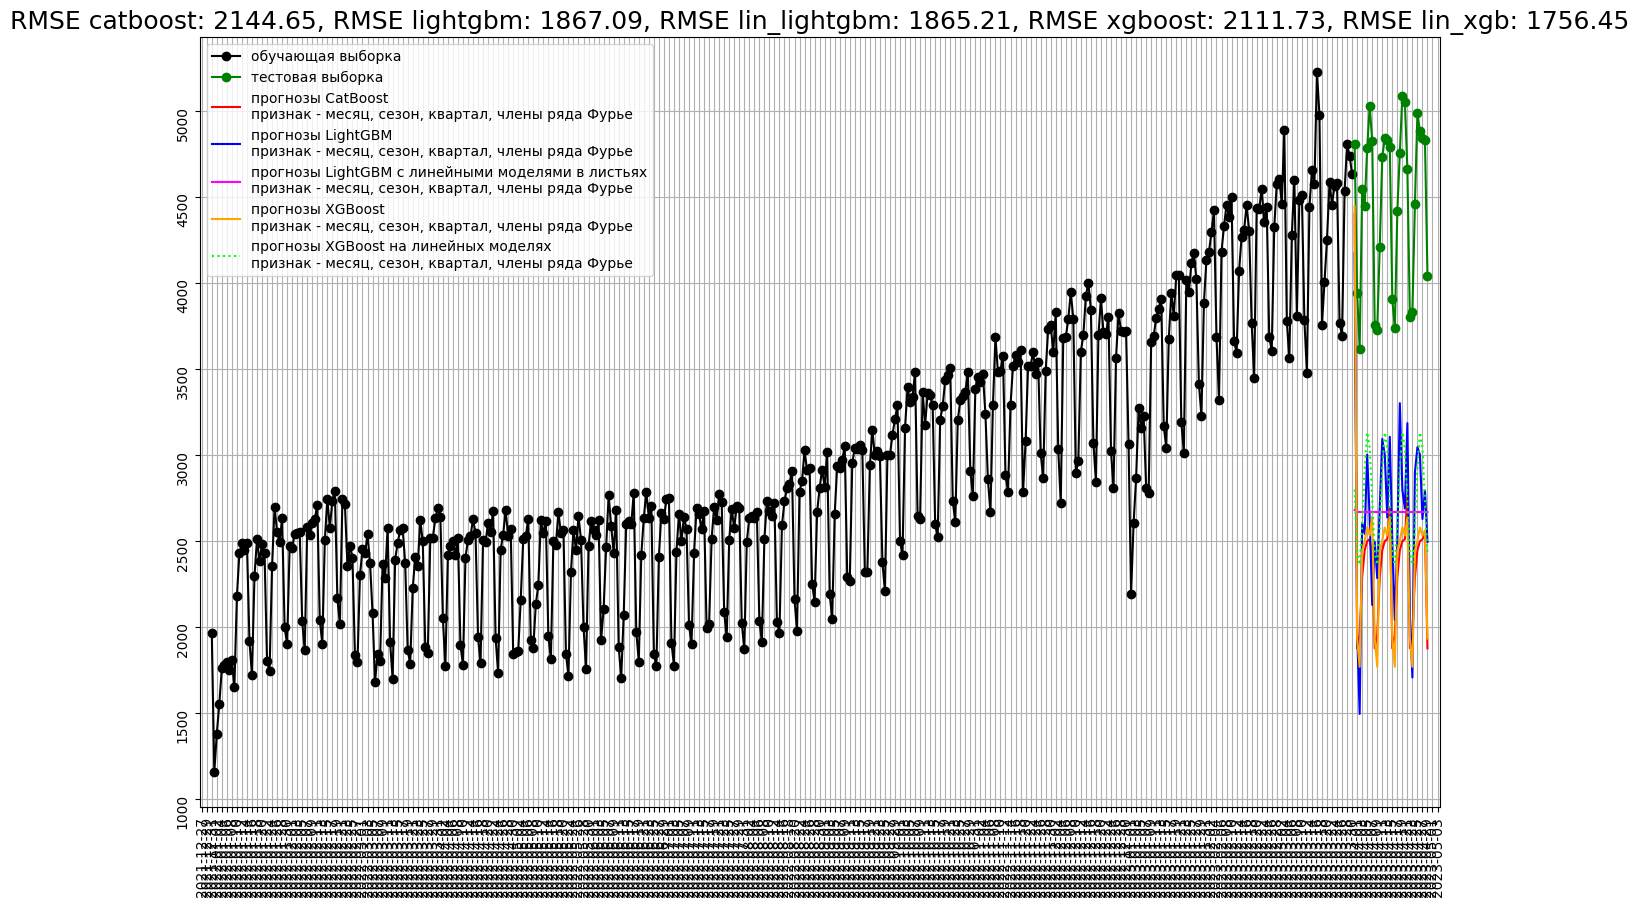

In [199]:
train_and_plot_forecast(X_train, y_train, X_test, y_test,
                        cat_feat=categorical_features,
                        text_for_legend='признак - месяц, сезон, квартал, члены ряда Фурье')

In [200]:
tmp_target = df['count'].copy()
tmp_target.iloc[-HORIZON:] = np.NaN
tmp_target

date
2021-12-31    1962.0
2022-01-01    1156.0
2022-01-02    1378.0
2022-01-03    1553.0
2022-01-04    1759.0
               ...  
2023-04-25       NaN
2023-04-26       NaN
2023-04-27       NaN
2023-04-28       NaN
2023-04-29       NaN
Name: count, Length: 485, dtype: float64

In [201]:
mean30 = pd.Series(name='mean30',
                   data=moving_stats(tmp_target, window=30),
                   index=df.index)

In [202]:
lag30 = pd.Series(name='lag30',
                  data=tmp_target.shift(30),
                  index=df.index)

In [203]:
diff_lag30 = pd.Series(name='diff_lag30',
                       data=lag30.diff(2),
                       index=df.index)

In [204]:
df_with_mean30 = pd.concat([df_fourier, mean30], axis=1)
df_with_lag30 = pd.concat([df_fourier, lag30], axis=1)
df_with_diff2_lag30 = pd.concat([df_fourier, diff_lag30], axis=1)

## Признаки - месяц, сезон, квартал, Фурье, mean30 RMSE - 190.14

In [205]:
X_train, X_test, y_train, y_test = fast_train_test_split(df_with_mean30, 'count', HORIZON)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


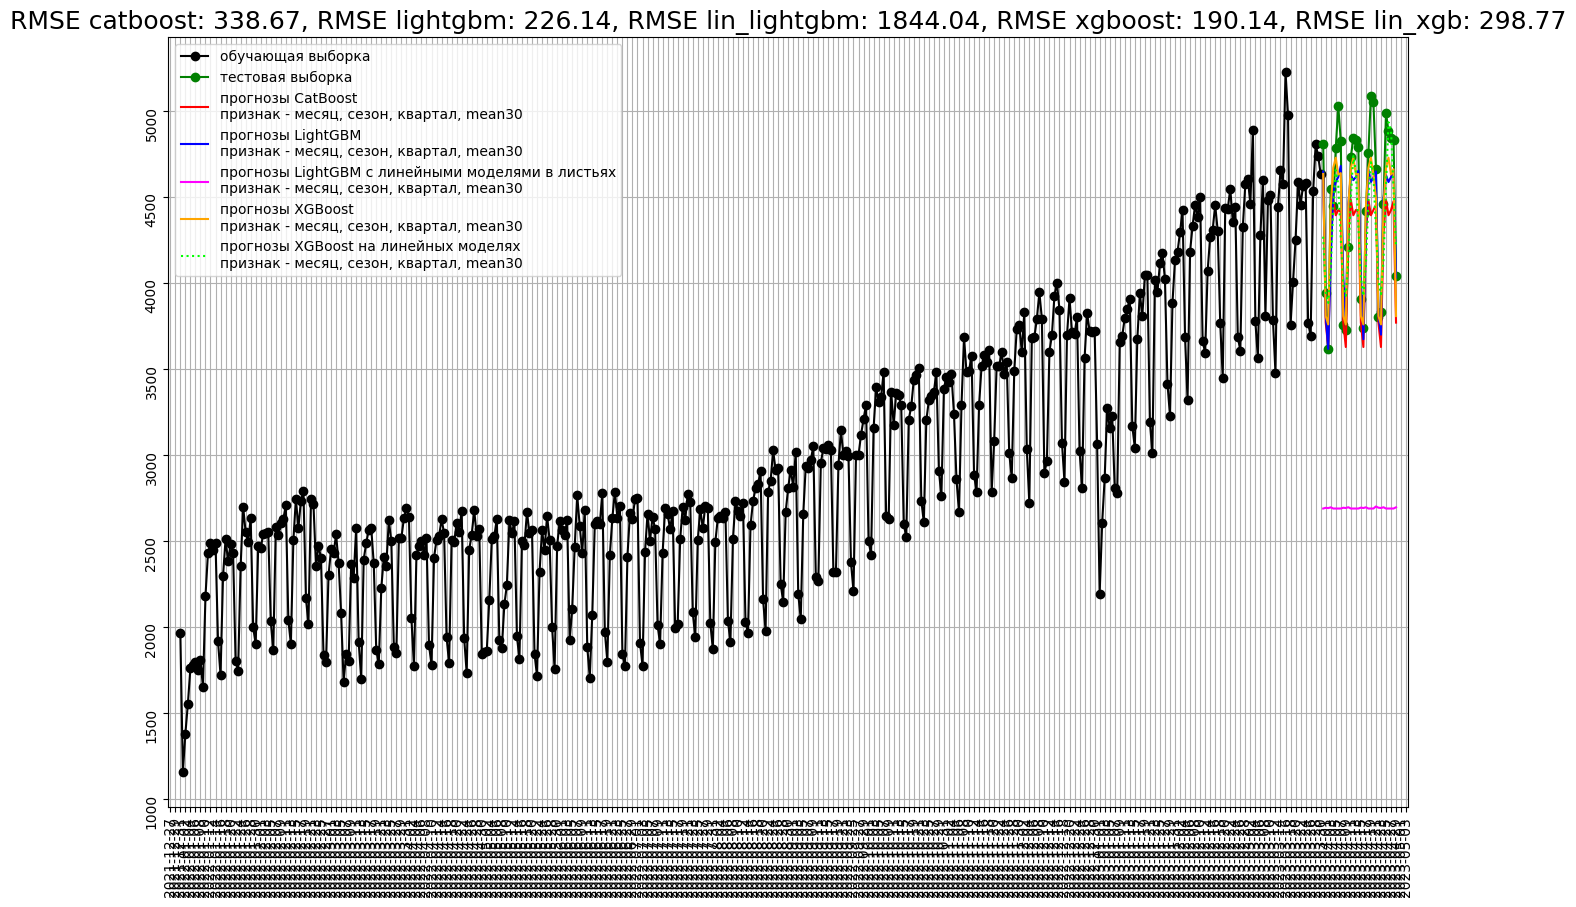

In [206]:
train_and_plot_forecast(X_train, y_train, X_test, y_test,
                        cat_feat=categorical_features,
                        text_for_legend='признак - месяц, сезон, квартал, mean30')

## Признаки - месяц, сезон, квартал, Фурье, lag30 RMSE - 226.86

In [207]:
X_train, X_test, y_train, y_test = fast_train_test_split(df_with_lag30, 'count', HORIZON)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


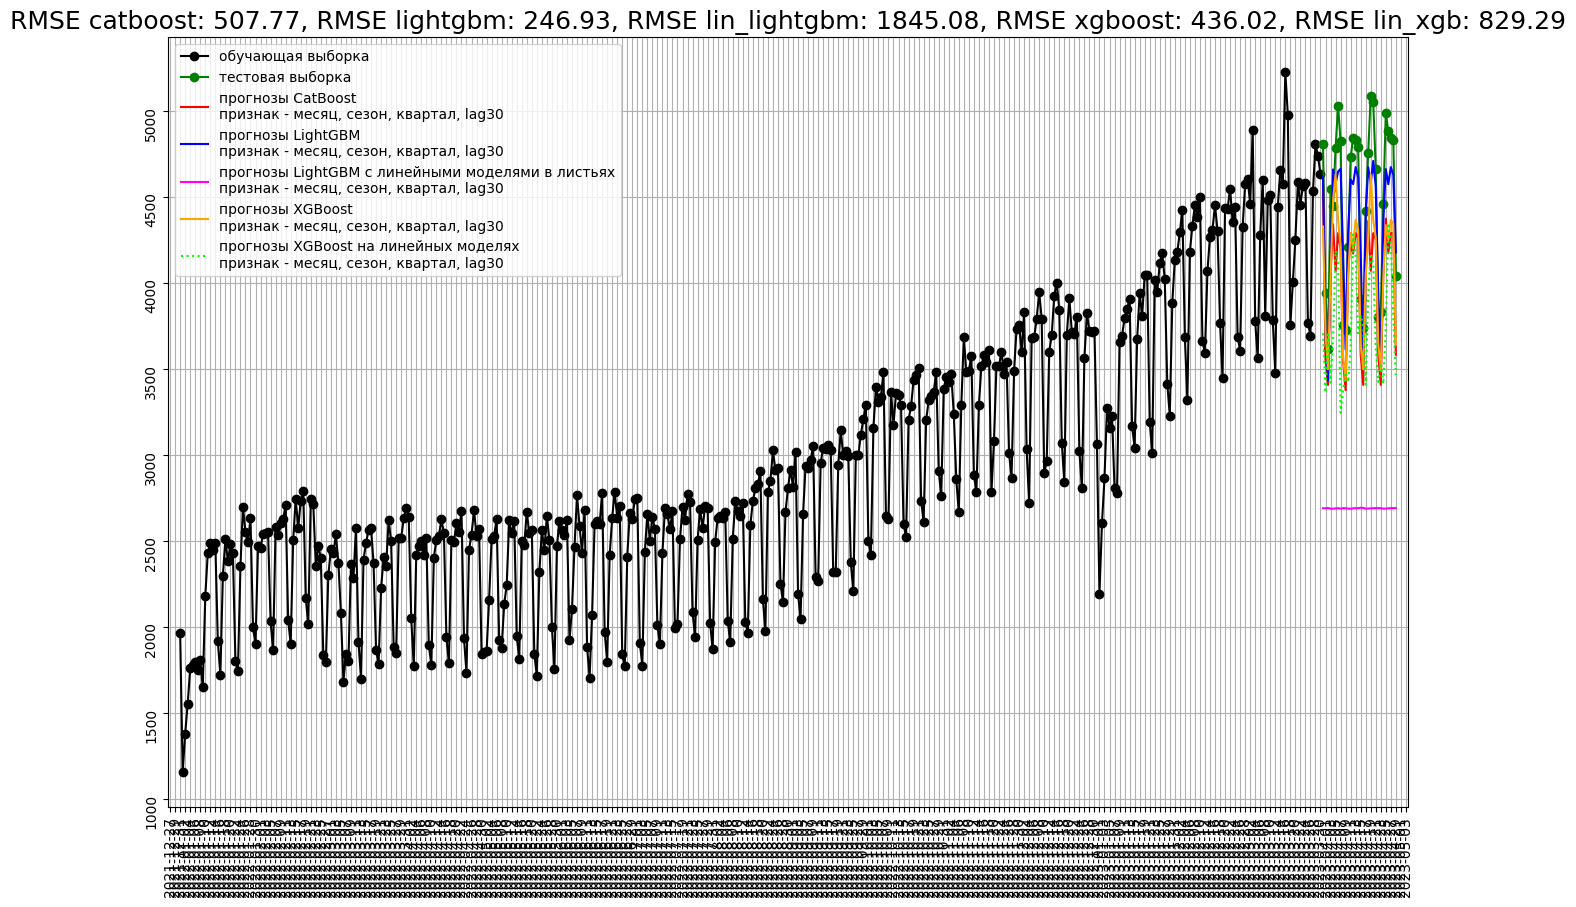

In [208]:
train_and_plot_forecast(X_train, y_train, X_test, y_test,
                        cat_feat=categorical_features,
                        text_for_legend='признак - месяц, сезон, квартал, lag30')

## Признаки - месяц, сезон, квартал, Фурье, diff2_lag30 RMSE - 240.88

In [209]:
X_train, X_test, y_train, y_test = fast_train_test_split(df_with_diff2_lag30, 'count', HORIZON)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


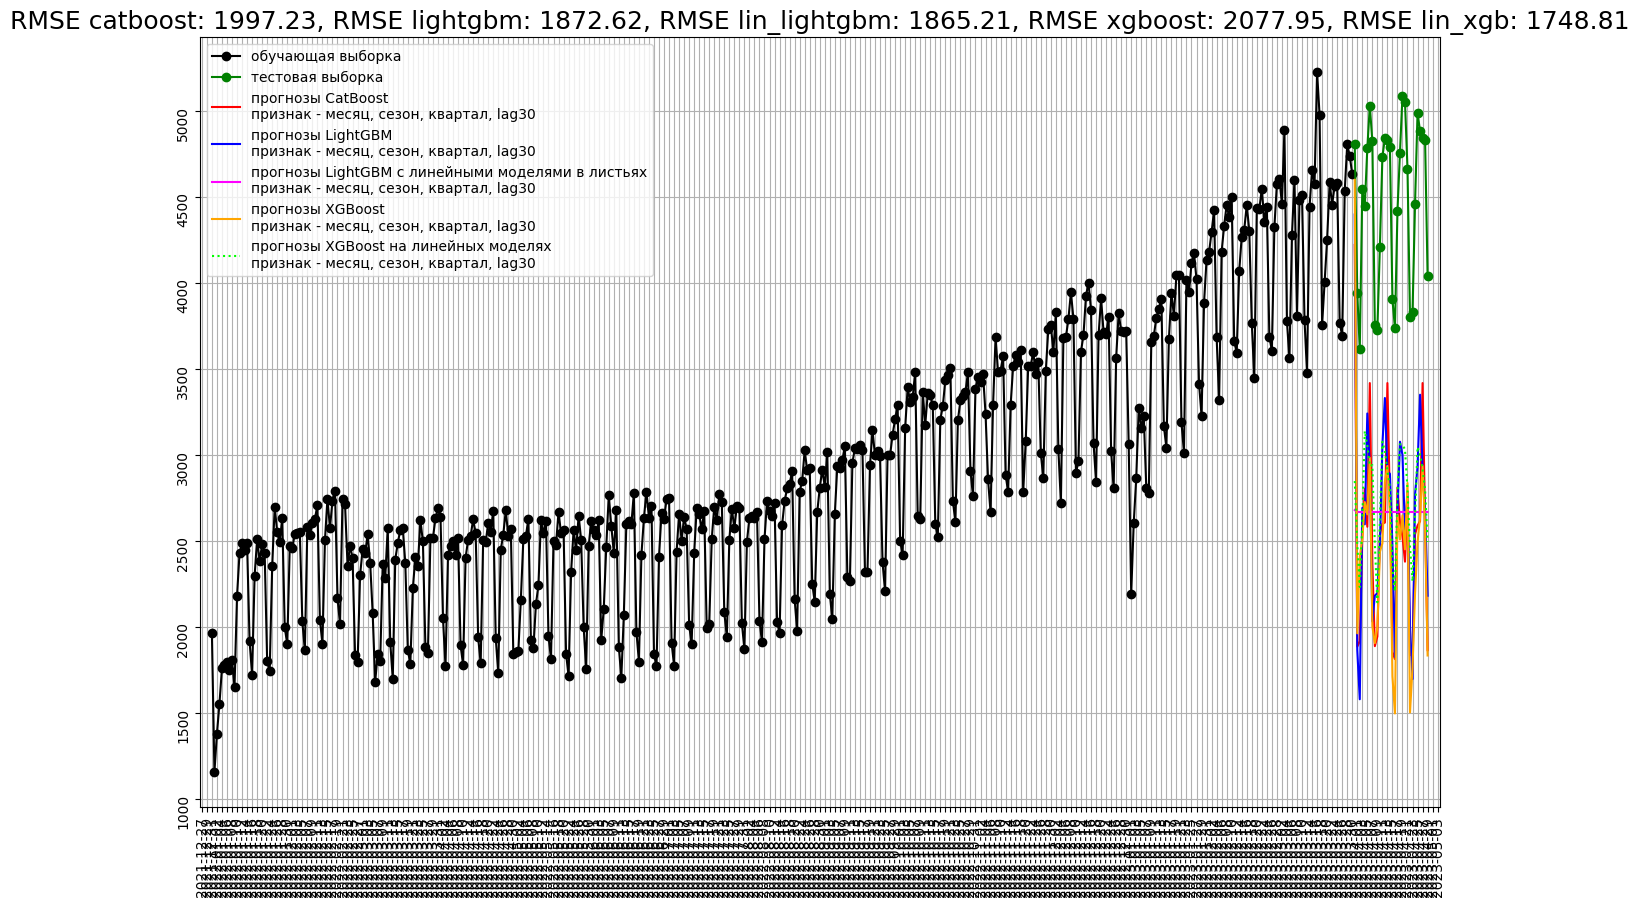

In [210]:
train_and_plot_forecast(X_train, y_train, X_test, y_test,
                        cat_feat=categorical_features,
                        text_for_legend='признак - месяц, сезон, квартал, lag30')

## Признаки - месяц, сезон, квартал, Фурье, mean30, lag30 RMSE - 197.72

In [211]:
df_with_mean30_lag30 = pd.concat([df_fourier, mean30, lag30], axis=1)

In [212]:
X_train, X_test, y_train, y_test = fast_train_test_split(df_with_mean30_lag30, 'count', HORIZON)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


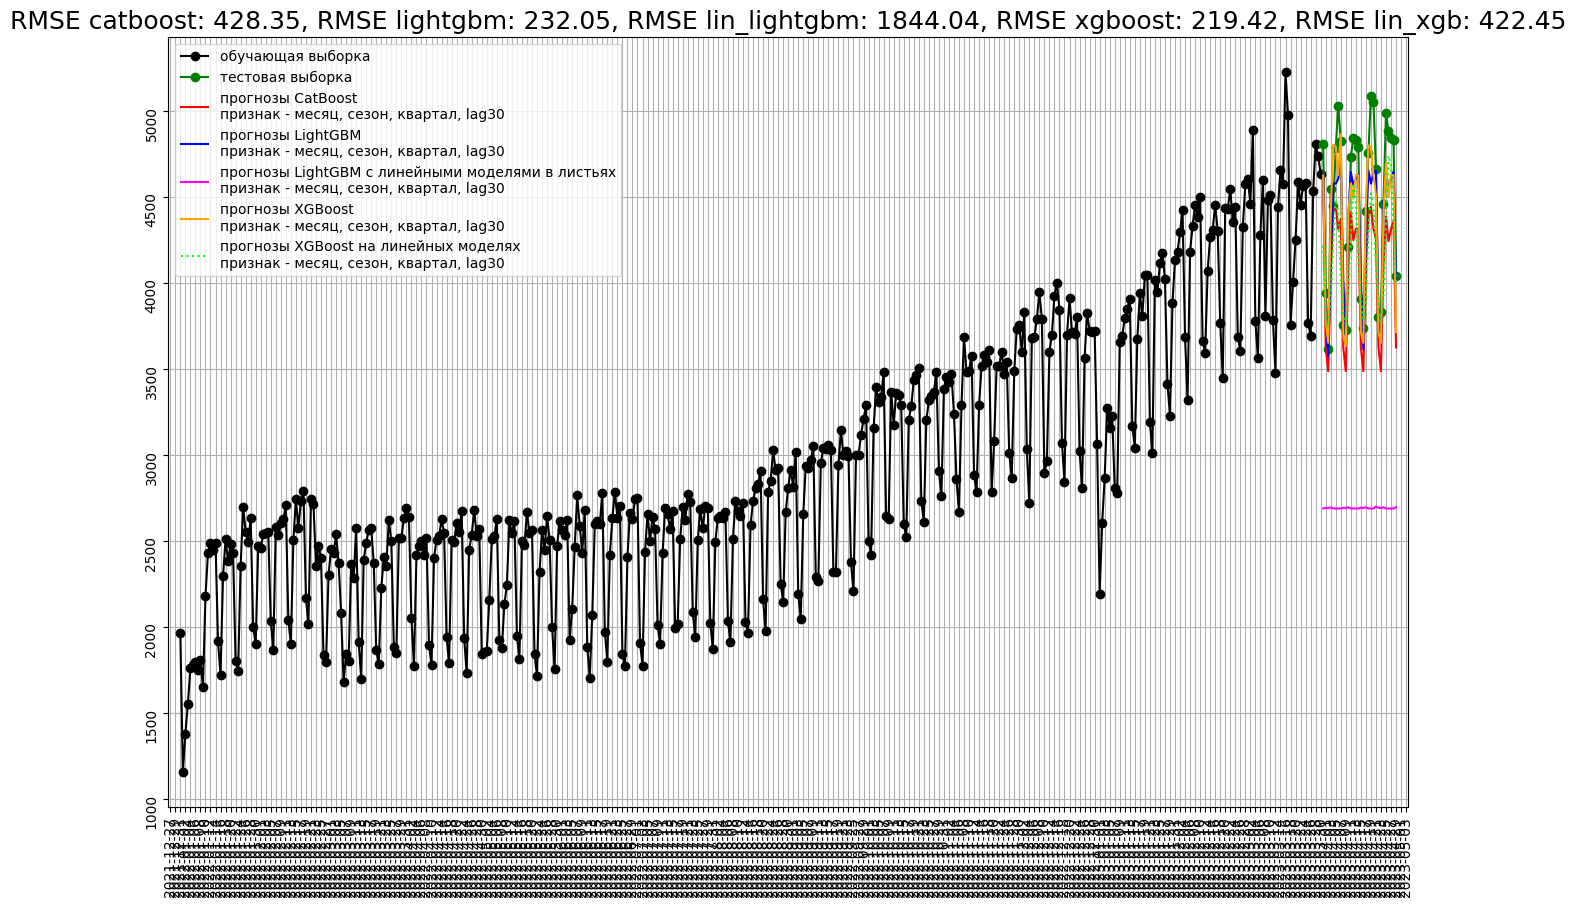

In [213]:
train_and_plot_forecast(X_train, y_train, X_test, y_test,
                        cat_feat=categorical_features,
                        text_for_legend='признак - месяц, сезон, квартал, lag30')

## Признаки - месяц, сезон, квартал, Фурье, mean30, lag30, diff_lag30 RMSE - 205.52

In [214]:
df_with_mean30_lag30_diff_lag30 = pd.concat([df_fourier, mean30, lag30, diff_lag30], axis=1)

In [215]:
X_train, X_test, y_train, y_test = fast_train_test_split(df_with_mean30_lag30_diff_lag30, 'count', HORIZON)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


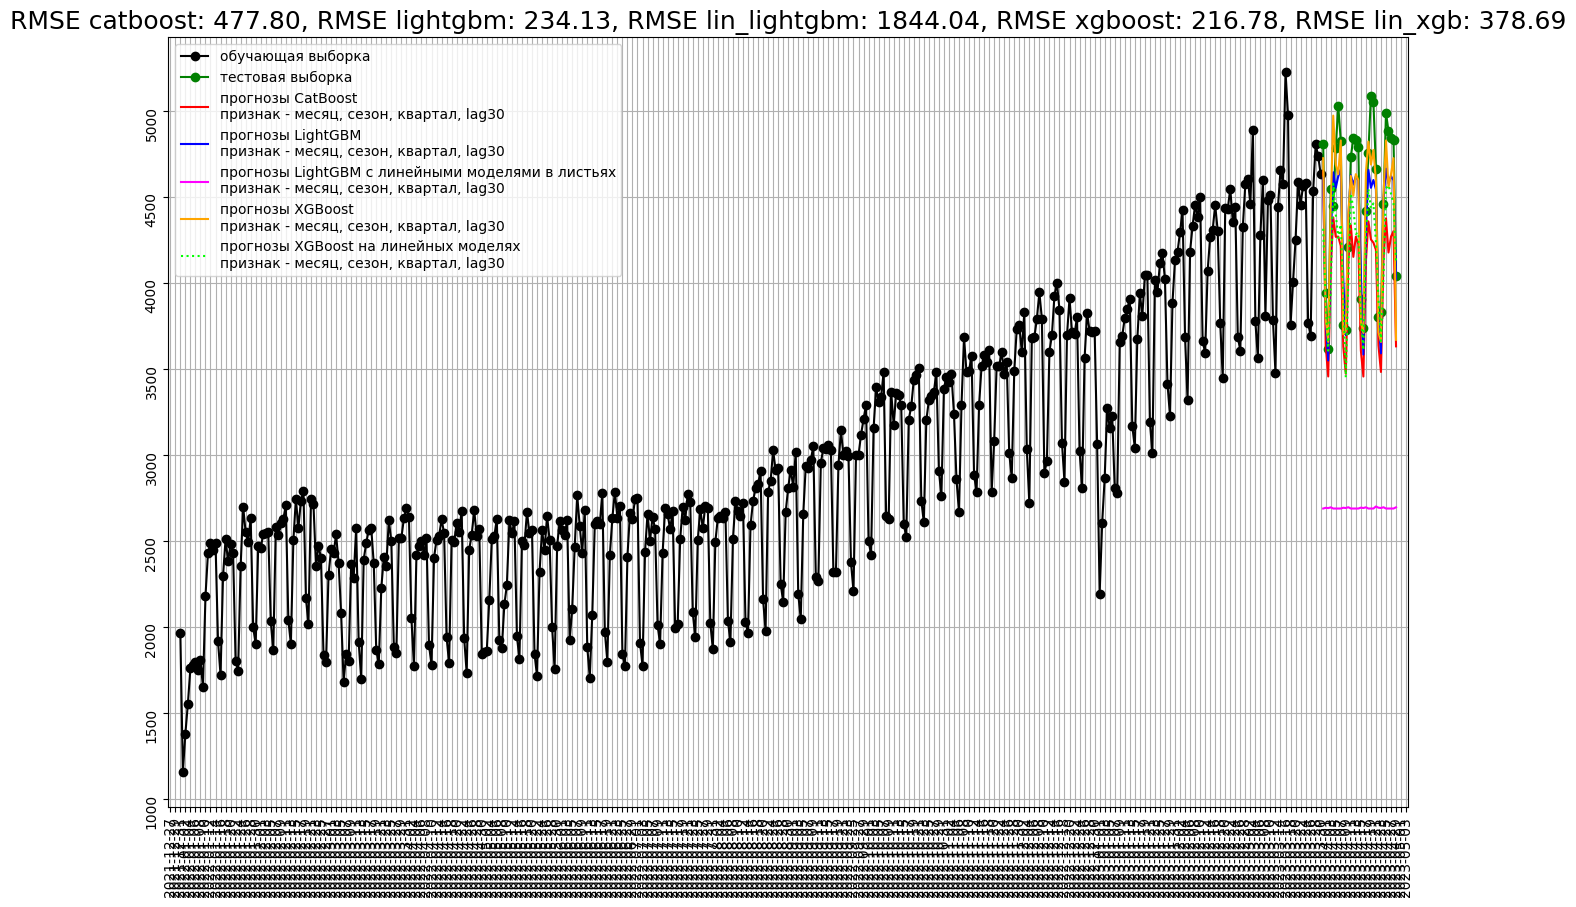

In [216]:
train_and_plot_forecast(X_train, y_train, X_test, y_test,
                        cat_feat=categorical_features,
                        text_for_legend='признак - месяц, сезон, квартал, lag30')

# Удаление тренда с последующим восстановлением

### Признаки - месяц, сезон, квартал, ряды Фурье без тренда RMSE - 148.38

In [217]:
def forecast_trend(tr_target,
                   calc_trend_for_tst_target=False,
                   degree=1,
                   test_size=4,
                   freq='MS'):
  regressor = make_pipeline(
      PolynomialFeatures(degree=degree, include_bias=True),
      LinearRegression(fit_intercept=False))
  n_timepoints = len(tr_target)

  X = np.arange(n_timepoints).reshape(-1, 1)

  regressor.fit(X, tr_target)
  coefs = regressor.named_steps['linearregression'].coef_

  tr_trend_pred = regressor.predict(X)
  tr_trend_pred = pd.Series(tr_trend_pred,
                            index=tr_target.index)
  if not calc_trend_for_tst_target:
    pass
  else:
    start= tr_trend_pred[-1] + coefs[1]
    count = test_size
    step = coefs[1]
    numbers = list()

    for i in range(count):
      numbers.append(start)
      start += step

    tst_trend_pred = pd.Series(numbers)

    if pd.__version__ >= '1.4':
      future_dates = pd.date_range(start = tr_target.index[-1],
                                   periods = test_size + 1,
                                   freq=freq,
                                   inclusive='right')
    else:
      future_dates = pd.date_range(start = tr_target.index[-1],
                                   periods = test_size + 1,
                                   freq=freq,
                                   closed='right')

    tst_trend_pred.index = future_dates

  if not calc_trend_for_tst_target:
    return tr_trend_pred, coefs
  else:
    return tr_trend_pred, tst_trend_pred

In [218]:
y_train_trend_pred, linreg_coefs = forecast_trend(y_train)

In [219]:
y_train_trend_pred.head()

date
2021-12-31    1768.058473
2022-01-01    1773.017387
2022-01-02    1777.976300
2022-01-03    1782.935214
2022-01-04    1787.894128
dtype: float64

In [220]:
y_train_detrended = y_train / y_train_trend_pred

In [221]:
y_train_detrended.head()

date
2021-12-31    1.109692
2022-01-01    0.651996
2022-01-02    0.775038
2022-01-03    0.871036
2022-01-04    0.983839
dtype: float64

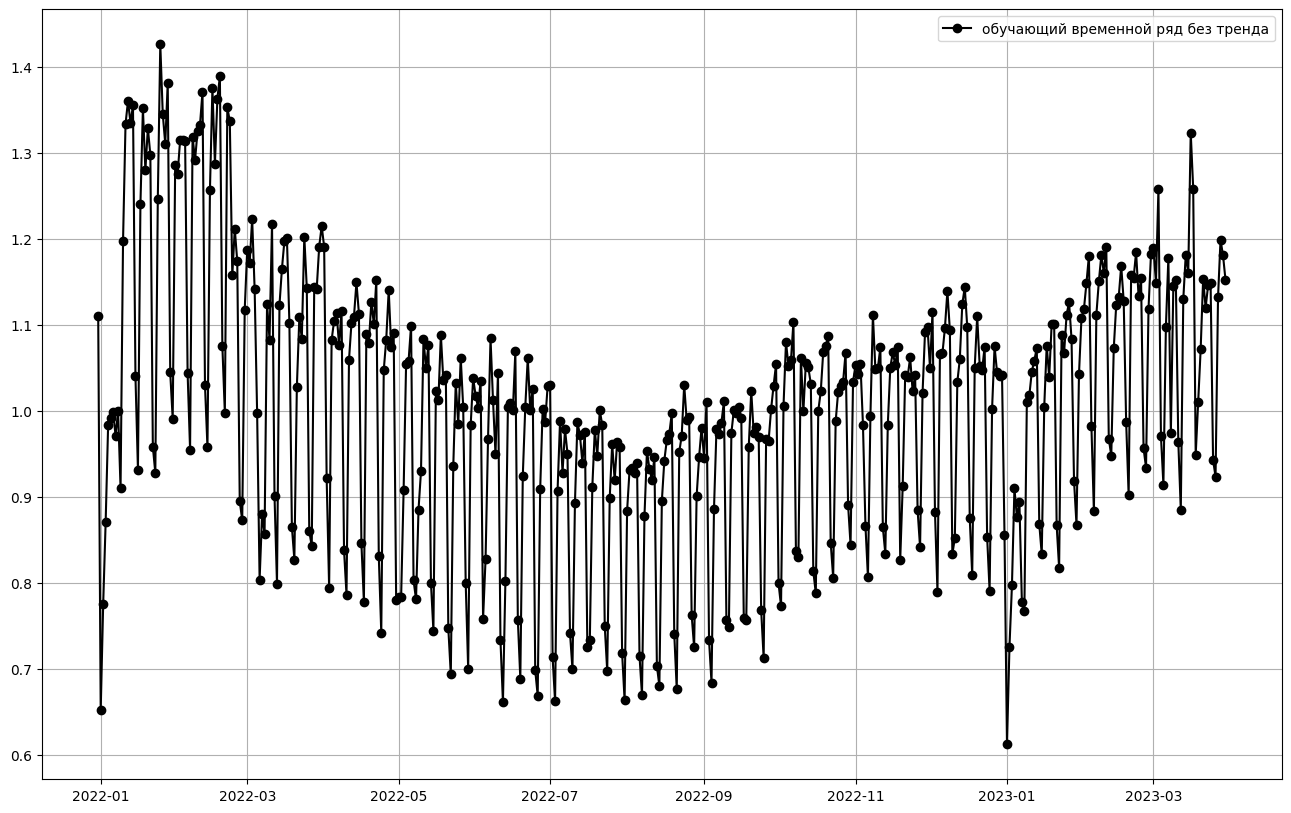

In [222]:
plt.figure(figsize=(16, 10))
plt.plot(y_train_detrended,
         color='black',
         label='обучающий временной ряд без тренда',
         marker = 'o')
plt.grid()
plt.legend()
plt.show()

In [223]:
start = y_train_trend_pred[-1] + linreg_coefs[1]
count = len(y_test)
step = linreg_coefs[1]
numbers = list()

for i in range(count):
  numbers.append(start)
  start += step

y_test_trend_pred = pd.Series(numbers)
y_test_trend_pred.index = y_test.index
y_test_trend_pred.head()

date
2023-03-31    4024.364177
2023-04-01    4029.323090
2023-04-02    4034.282004
2023-04-03    4039.240918
2023-04-04    4044.199831
dtype: float64

In [224]:
text = 'признаки - месяц, сезон, квартл, ряды Фурье, с удалением тренда'

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


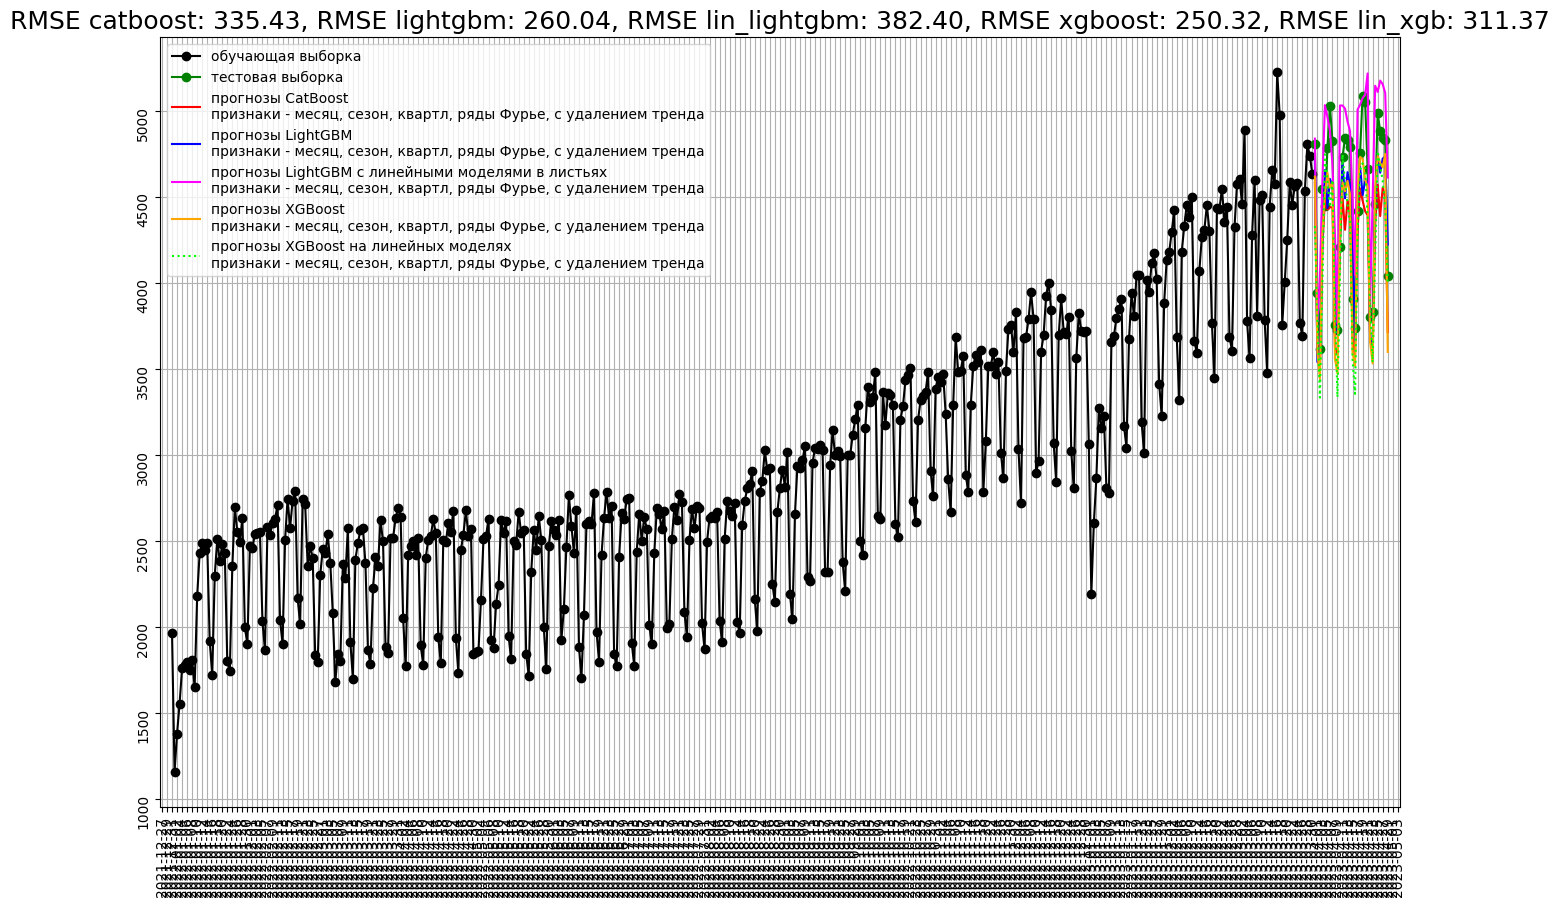

In [225]:
train_and_plot_forecast(
    X_train,
    y_train_detrended,
    X_test,
    y_test,
    cat_feat=categorical_features,
    preprocess_trend_and_seasonality='fast_mul',
    y_tr_trend_pred=y_train_trend_pred,
    y_tst_trend_pred=y_test_trend_pred,
    text_for_legend = text
)

### Признаки - месяц, сезон, квартал, ряды Фурье, lag30, diff2_lag30 без тренда RMSE - 162.24

In [226]:
tmp_detrended_terget = pd.concat([y_train_detrended, y_test])
tmp_detrended_terget.iloc[-HORIZON:] = np.NaN
tmp_detrended_terget

date
2021-12-31    1.109692
2022-01-01    0.651996
2022-01-02    0.775038
2022-01-03    0.871036
2022-01-04    0.983839
                ...   
2023-04-25         NaN
2023-04-26         NaN
2023-04-27         NaN
2023-04-28         NaN
2023-04-29         NaN
Length: 485, dtype: float64

In [227]:
lag30 = pd.Series(name='lag30',
                  data=tmp_detrended_terget.shift(30),
                  index=df.index)
diff2_lag30 = pd.Series(name='diff2_lag30',
                        data=lag30.diff(2),
                        index = df.index)

In [228]:
df_with_lag30_diff2_lag30 = pd.concat([df_fourier, lag30, diff2_lag30], axis=1)

In [ ]:
df_with_lag30_diff2_lag30.head()

count  month  season  quarter  fourier_year_1  fourier_year_2  \
date                                                                        
2021-12-31   1962     12  WINTER        4        0.000000        1.000000   
2022-01-01   1156      1  WINTER        1        0.781831        0.623490   
2022-01-02   1378      1  WINTER        1        0.974928       -0.222521   
2022-01-03   1553      1  WINTER        1        0.433884       -0.900969   
2022-01-04   1759      1  WINTER        1       -0.433884       -0.900969   

            lag30  diff2_lag30  
date                            
2021-12-31    NaN          NaN  
2022-01-01    NaN          NaN  
2022-01-02    NaN          NaN  
2022-01-03    NaN          NaN  
2022-01-04    NaN          NaN

In [229]:
X_train, X_test, y_train, y_test = fast_train_test_split(
    df_with_lag30_diff2_lag30,'count', HORIZON)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


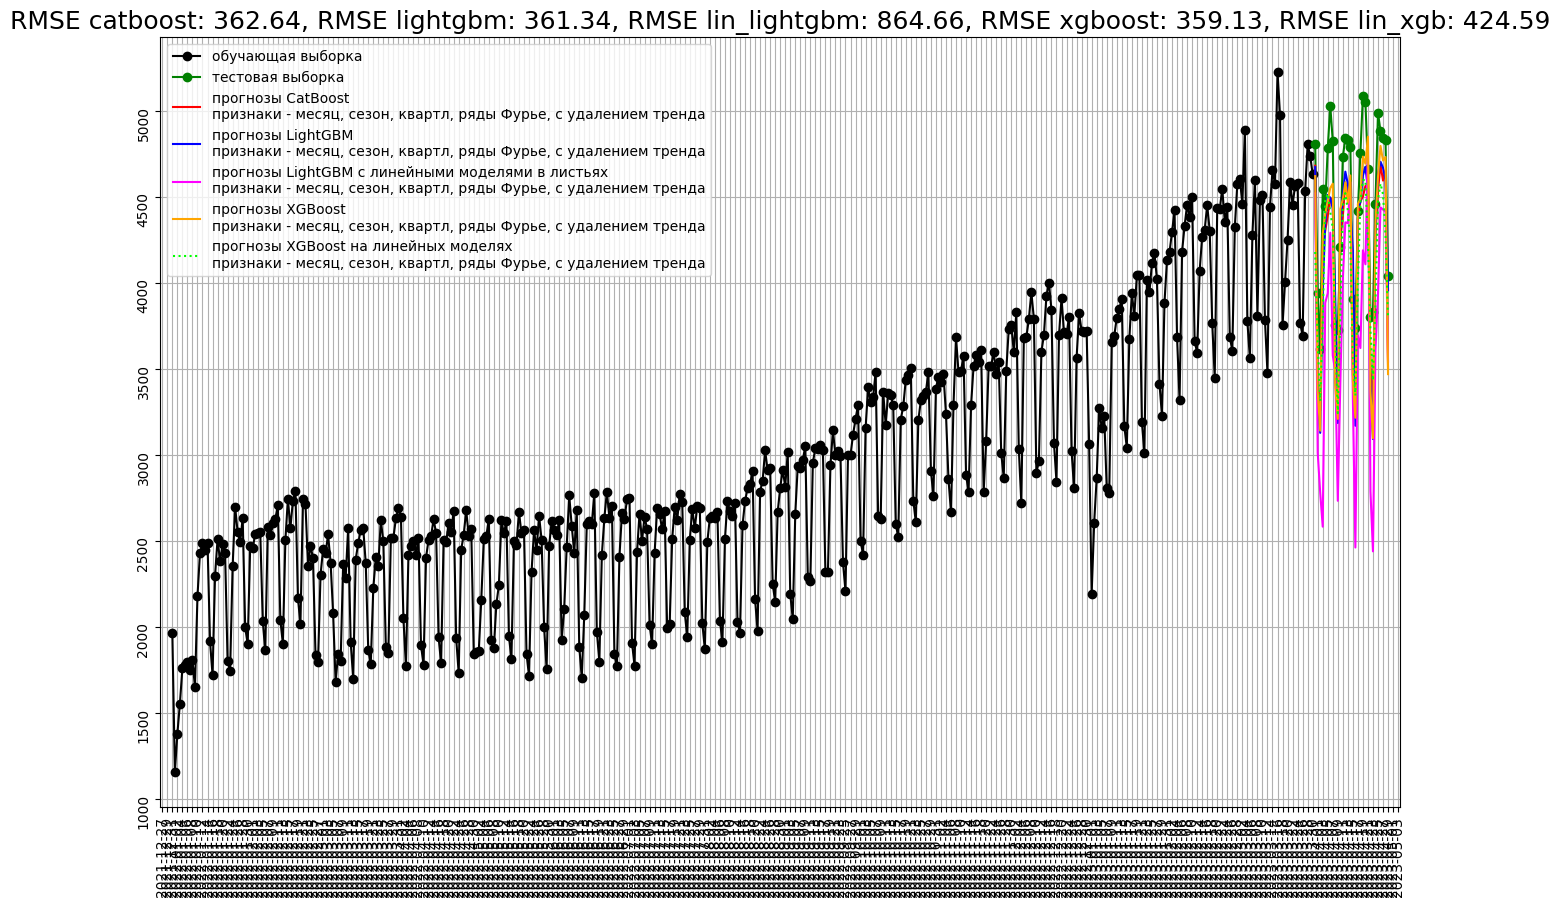

In [230]:
train_and_plot_forecast(
    X_train,
    y_train_detrended,
    X_test,
    y_test,
    cat_feat=categorical_features,
    preprocess_trend_and_seasonality='fast_mul',
    y_tr_trend_pred=y_train_trend_pred,
    y_tst_trend_pred=y_test_trend_pred,
    text_for_legend = text
)

### Признаки - месяц, сезон, квартал, ряды Фурье, lag60, diff2_lag60 без тренда RMSE - 122.27

In [239]:
lag60 = pd.Series(name='lag60',
                  data=tmp_detrended_terget.shift(90),
                  index=df.index)
diff2_lag60 = pd.Series(name='diff2_lag60',
                        data=lag30.diff(2),
                        index = df.index)

In [240]:
df_with_lag60_diff2_lag60 = pd.concat([df_fourier, lag60, diff2_lag60], axis=1)

In [ ]:
df_with_lag60_diff2_lag60

count  month  season  quarter  fourier_year_1  fourier_year_2  \
date                                                                        
2021-12-31   1962     12  WINTER        4    0.000000e+00        1.000000   
2022-01-01   1156      1  WINTER        1    7.818315e-01        0.623490   
2022-01-02   1378      1  WINTER        1    9.749279e-01       -0.222521   
2022-01-03   1553      1  WINTER        1    4.338837e-01       -0.900969   
2022-01-04   1759      1  WINTER        1   -4.338837e-01       -0.900969   
...           ...    ...     ...      ...             ...             ...   
2022-12-27   3825     12  WINTER        4   -4.338837e-01       -0.900969   
2022-12-28   3722     12  WINTER        4   -9.749279e-01       -0.222521   
2022-12-29   3714     12  WINTER        4   -7.818315e-01        0.623490   
2022-12-30   3722     12  WINTER        4    1.568538e-14        1.000000   
2022-12-31   3062     12  WINTER        4    7.818315e-01        0.623490   

               lag60  diff2_lag60  
date                               
2021-12-31       NaN          NaN  
2022-01-01       NaN          NaN  
2022-01-02       NaN          NaN  
2022-01-03       NaN          NaN  
2022-01-04       NaN          NaN  
...              ...          ...  
2022-12-27  1.157009    -0.219092  
2022-12-28  0.965779     0.150301  
2022-12-29  0.915593     0.275590  
2022-12-30  1.121567     0.084307  
2022-12-31  1.143114    -0.045831  

[366 rows x 8 columns]

In [241]:
X_train, X_test, y_train, y_test = fast_train_test_split(
    df_with_lag60_diff2_lag60,'count', HORIZON)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


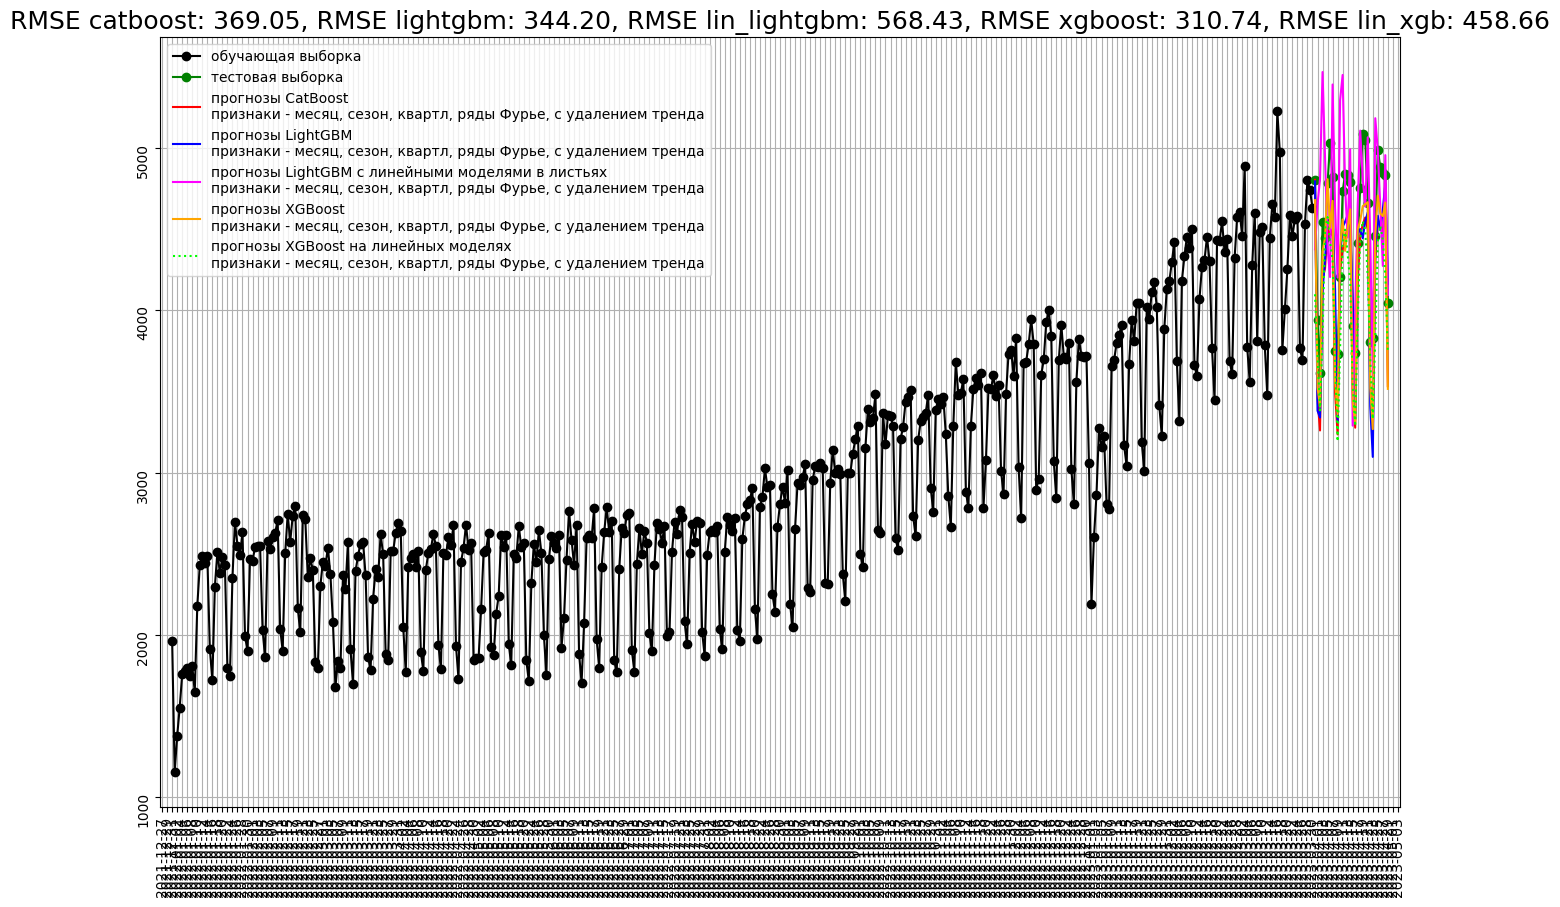

In [242]:
train_and_plot_forecast(
    X_train,
    y_train_detrended,
    X_test,
    y_test,
    cat_feat=categorical_features,
    preprocess_trend_and_seasonality='fast_mul',
    y_tr_trend_pred=y_train_trend_pred,
    y_tst_trend_pred=y_test_trend_pred,
    text_for_legend = text
)

### Признаки - месяц, сезон, квартал, ряды Фурье, lag60, diff2_lag60, тренд как признак RMSE - 137.08

In [235]:
trend = pd.concat([y_train_trend_pred, y_test_trend_pred],axis=0)
trend = pd.Series(name='trend',
                  data=trend,
                  index=df.index)

In [236]:
df_with_lag60_diff2_lag60_trend = pd.concat([df_fourier, lag60, diff2_lag60, trend], axis=1)

In [237]:
X_train, X_test, y_train, y_test = fast_train_test_split(
    df_with_lag60_diff2_lag60_trend,'count', HORIZON)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


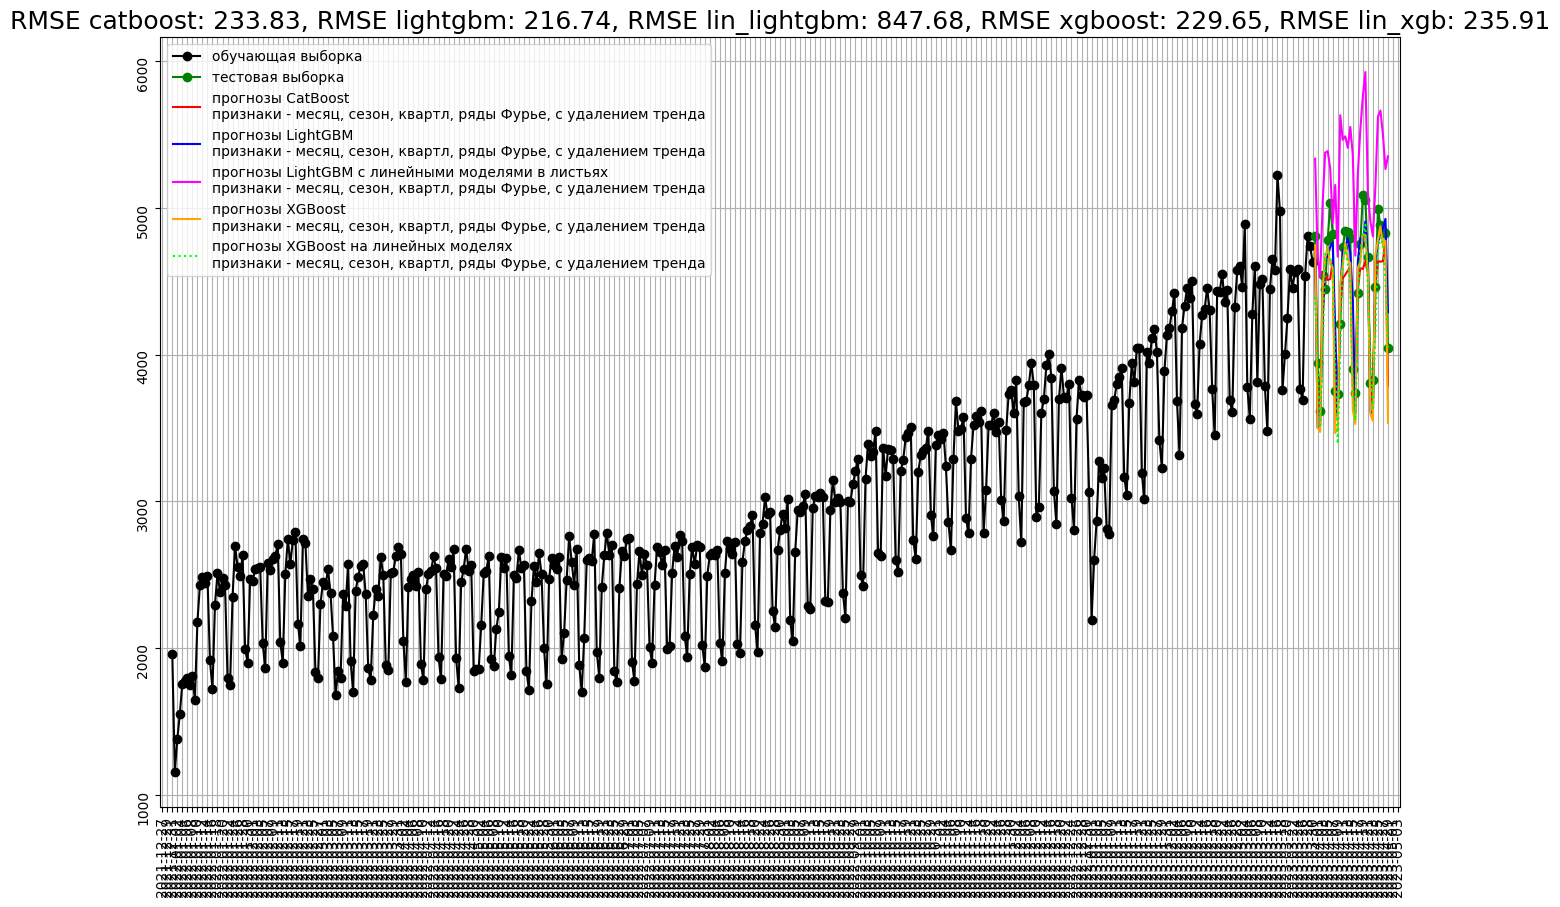

In [238]:
train_and_plot_forecast(
    X_train,
    y_train_detrended,
    X_test,
    y_test,
    cat_feat=categorical_features,
    preprocess_trend_and_seasonality='fast_mul',
    y_tr_trend_pred=y_train_trend_pred,
    y_tst_trend_pred=y_test_trend_pred,
    text_for_legend = text
)

# Facebook Prophet

In [ ]:
!pip install prophet

In [60]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [85]:
df = pd.read_csv(DATA_PATH + 'time_series_to_may.csv',
                 parse_dates=['date'])

In [86]:
df.columns = ['ds', 'y']

In [87]:
df.head()

ds     y
0 2021-12-31  1962
1 2022-01-01  1156
2 2022-01-02  1378
3 2022-01-03  1553
4 2022-01-04  1759

In [ ]:
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [ ]:
df.shape

(366, 2)

In [88]:
model = Prophet(seasonality_mode='additive')

In [90]:
train = df.loc[df['ds'] <= '2023-03-31']
test = df.loc[df['ds'] >= '2023-03-31']
print(train.shape)
print(test.shape)

(456, 2)
(30, 2)


In [91]:
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ng_0kna/hlme9r_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ng_0kna/j15palh8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83928', 'data', 'file=/tmp/tmp8ng_0kna/hlme9r_k.json', 'init=/tmp/tmp8ng_0kna/j15palh8.json', 'output', 'file=/tmp/tmp8ng_0kna/prophet_modelicmbhbpa/prophet_model-20230620085501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:55:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:55:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [92]:
future = model.make_future_dataframe(periods=30)

In [93]:
future

ds
0   2021-12-31
1   2022-01-01
2   2022-01-02
3   2022-01-03
4   2022-01-04
..         ...
481 2023-04-26
482 2023-04-27
483 2023-04-28
484 2023-04-29
485 2023-04-30

[486 rows x 1 columns]

In [94]:
forecast = model.predict(future)

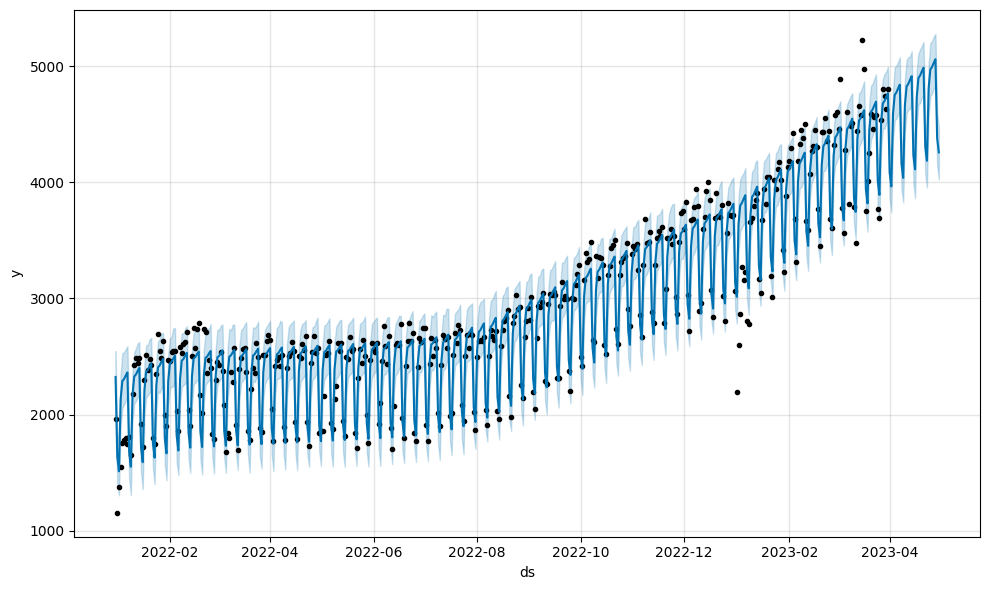

In [95]:
fig=model.plot(forecast)
plt.show()

In [99]:
preds = forecast.set_index('ds')['2023-04-01': '2023-04-30']['yhat']

In [100]:
preds.shape

(30,)

In [101]:
rmse = mean_squared_error(test['y'], preds, squared=False)
print(rmse)

478.94089561617466
